
* Correct the data generator. 
* Add location
* Add bus models
* Add uncertainities
* Finalize, correct the rest of the stuff visualization etc.
  

In [141]:
import random
import math
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Optional
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
import networkx as nx

In [142]:
# --- (CONFIGURATION) ---
NUM_CANDIDATE_ECUS = 10  
NUM_SCS = 20 
VEHICLE_DIMS = (100, 50)

In [143]:
# Data Classes
@dataclass
class Point:
    x: float
    y: float

    def dist(self, other):
        manhattan = abs(self.x - other.x) + abs(self.y - other.y) # Manhattan Distance 
        euclidean = math.sqrt((self.x - other.x)**2 + (self.y - other.y)**2) # Euclidean Distance
        return manhattan, euclidean

@dataclass
class Sensor:
    id: str
    #location: Point
    type: str # 'CAMERA', 'LIDAR', 'RADAR', 'ULTRASONIC', etc.
    interface: str # 'CAN', 'ETH', 'LIN', 'FLEXRAY', etc.
    volume: float  # MB/s

@dataclass
class Actuator:
    id: str
    #location: Point
    type: str  # 'BRAKE', 'STEERING', 'HVAC', 'SEAT', etc.
    interface: str  # 'CAN', 'ETH', 'LIN', 'FLEXRAY', etc.
    volume: float  # MB/s 

@dataclass
class SoftwareComponent:
    id: str
    domain: str        
    cpu_req: int
    ram_req: int
    rom_req: int
    #connected_sensors: List[str] # Sensor ID'leri
    asil_req: int # 'QM', 'ASIL-B', 'ASIL-D'
    hw_required: list   # List of HW features required

@dataclass
class CandidateECU:
    id: str
    #location: Point
    cpu_cap: int        # DMIPS
    ram_cap: int        # MB
    rom_cap: int        # MB
    max_containers: int # How many containers can be hosted
    cost: int           # Cost
    type: str           # 'HPC', 'ZONAL', 'MCU'
    asil_level: int     # 'QM', 'ASIL-B', 'ASIL-D'
    hw_offered: list    # List of HW features (e.g. ['HW_ACC', 'HW_ETH'])

In [144]:
class VehicleDataGenerator:
    def __init__(self):
        random.seed(42)  # For reproducibility
        self.sensors = []
        self.actuators = []
        self.ecus = []
        self.scs = []

    def generate_sensors_and_actuators(self):
        # Define available sensors and actuators with interfaces and data volumes
        sensor_types = [
            ('CAMERA', 1, 'ETH', 80.0),      # High bandwidth video
            ('LIDAR', 1, 'ETH', 15.0),       # Medium bandwidth point cloud
            ('RADAR', 1, 'CAN', 8.0),        # Lower bandwidth signals
        ]
        actuator_types = [
            ('BRAKE', 1, 'CAN', 2.0),        # Control commands
            ('STEERING', 1, 'FLEXRAY', 1.0), # Precise steering command
            ('MOTOR', 1, 'CAN', 3.0),        # Motor control
            ('HVAC', 1, 'LIN', 0.5),         # Simple HVAC commands
        ]

        # Generate sensors
        idx = 0
        for s_type, count, interface, volume in sensor_types:
            for i in range(count):
                sensor = Sensor(
                    id=f"S_{idx}_{s_type}",
                    type=s_type,
                    interface=interface,
                    volume=volume
                )
                self.sensors.append(sensor)
                idx += 1

        # Generate actuators
        idx = 0
        for a_type, count, interface, volume in actuator_types:
            for i in range(count):
                actuator = Actuator(
                    id=f"A_{idx}_{a_type}",
                    type=a_type,
                    interface=interface,
                    volume=volume
                )
                self.actuators.append(actuator)
                idx += 1

    def generate_ecu(self):
        # HW feature sets
        hpc_hw = ['HW_ACC', 'HW_ETH', 'HW_HSM']
        zone_hw = ['HW_CANFD', 'HW_FLEX', 'HW_ETH', 'HW_LIN']
        mcu_hw = ['HW_CANFD', 'HW_LIN']

        # Create Candidate ECUs
        for i in range(NUM_CANDIDATE_ECUS):
            r = random.random()
            
            if r < 0.10: # %10 HPC 
                ecu = CandidateECU(
                    id=f"ECU_{i}_HPC",
                    cpu_cap=200000,
                    ram_cap=64000,
                    rom_cap=256000,  # 256 GB Storage
                    max_containers=16, 
                    cost=1000,
                    type='HPC',
                    asil_level=2, # Lets make it QM/B 
                    hw_offered=hpc_hw
                )
            elif r < 0.40: # %30 Safety Controller
                ecu = CandidateECU(
                    id=f"ECU_{i}_SAFE",
                    cpu_cap=30000,
                    ram_cap=4000,
                    rom_cap=8000,
                    max_containers=4,
                    cost=300, 
                    type='ZONE', 
                    asil_level=4, # Supports ASIL-D
                    hw_offered=zone_hw
                )
            else: # %60 Edge MCU
                ecu = CandidateECU(
                    id=f"ECU_{i}_MCU",
                    cpu_cap=5000, 
                    ram_cap=512,
                    rom_cap=2048, 
                    max_containers=1, 
                    cost=50, 
                    type='MCU', 
                    asil_level=2,
                    hw_offered=mcu_hw
                )
            self.ecus.append(ecu)

    def generate_scs(self):
        # 5 Different Domains
        domains = [
            "ADAS", 
            "Infotainment", 
            "VehicleDynamics", 
            "BodyComfort", 
            "Connectivity"
        ]
        
        # HW requirements per domain
        domain_hw = {
            "ADAS": ['HW_ACC', 'HW_ETH'],
            "Infotainment": ['HW_ETH', 'HW_USB'],
            "VehicleDynamics": ['HW_CANFD'],
            "BodyComfort": ['HW_LIN'],
            "Connectivity": ['HW_ETH', 'HW_BT']
        }

        # Distribution Weights of Domains
        weights = [0.15, 0.15, 0.20, 0.35, 0.15] 
        assigned_domains = random.choices(domains, weights=weights, k=NUM_SCS)

        for i, domain in enumerate(assigned_domains):
            hw_req = domain_hw[domain]
            if domain == "ADAS":
                # High CPU (AI), High RAM (Image Buffers), Mixed Safety
                sc = SoftwareComponent(
                    id=f"SC_{i}_ADAS", domain=domain,
                    cpu_req=random.randint(15000, 40000),
                    ram_req=random.randint(2000, 8000),
                    rom_req=random.randint(50, 200),
                    asil_req=random.choice([2, 4]), # ASIL-B (Perception) or D (Planning)
                    hw_required=hw_req
                )

            elif domain == "Infotainment":
                # High CPU, Very High RAM, Low Safety
                sc = SoftwareComponent(
                    id=f"SC_{i}_IVI", domain=domain,
                    cpu_req=random.randint(10000, 30000),
                    ram_req=random.randint(4000, 16000), # RAM inttensive for graphics
                    rom_req=random.randint(20, 100),
                    asil_req=0, # QM
                    hw_required=hw_req
                )

            elif domain == "VehicleDynamics":
                # Low/Mid CPU (Fast Loops), Low RAM, Highest Safety
                sc = SoftwareComponent(
                    id=f"SC_{i}_Dyn", domain=domain,
                    cpu_req=random.randint(1000, 5000),
                    ram_req=random.randint(64, 256),
                    rom_req=random.randint(10, 50),
                    asil_req=4, # ASIL-D (Brake, Engine Control)
                    hw_required=hw_req
                )

            elif domain == "BodyComfort":
                # Low CPU, Low RAM, Low/Mid Safety
                sc = SoftwareComponent(
                    id=f"SC_{i}_Body", domain=domain,
                    cpu_req=random.randint(200, 1000),
                    ram_req=random.randint(16, 64),
                    rom_req=random.randint(5, 20),
                    asil_req=random.choice([0, 1, 2]), # QM, A, B
                    hw_required=hw_req
                )

            elif domain == "Connectivity":
                # Mid CPU (Crypto/Gateway), Mid RAM, Mid Safety
                sc = SoftwareComponent(
                    id=f"SC_{i}_Conn", domain=domain,
                    cpu_req=random.randint(3000, 8000),
                    ram_req=random.randint(256, 1024),
                    rom_req=random.randint(50, 200),
                    asil_req=2, # ASIL-B
                    hw_required=hw_req
                )
            
            self.scs.append(sc)

        # Assign required sensors/actuators to each SC
        all_sensor_ids = [s.id for s in self.sensors]
        all_actuator_ids = [a.id for a in self.actuators]
        for sc in self.scs:
            # Assign 0-2 sensors and 0-2 actuators randomly
            sc.sensors = random.sample(all_sensor_ids, k=random.randint(0, min(2, len(all_sensor_ids))))
            sc.actuators = random.sample(all_actuator_ids, k=random.randint(0, min(2, len(all_actuator_ids))))

    def generate_comm_matrix(self):
        # SW-to-SW communication matrix with max tolerated latency
        comm_matrix = []  # List of dicts: {src, dst, volume, max_latency}
        for i, src in enumerate(self.scs):
            for j, dst in enumerate(self.scs):
                if i != j:
                    # Randomly decide if there is communication (30% chance)
                    if random.random() < 0.3:
                        # Communication volume (MB/s) and max tolerated latency (ms)
                        volume = random.randint(1, 50)
                        # Latency can depend on domain similarity
                        if src.domain == dst.domain:
                            max_latency = random.randint(1, 10)  # Tighter for same domain
                        else:
                            max_latency = random.randint(10, 100)  # Looser for cross-domain
                        comm_matrix.append({
                            'src': src.id,
                            'dst': dst.id,
                            'volume': volume,
                            'max_latency': max_latency,
                        })
        return comm_matrix

    def generate_data(self):
        self.generate_sensors_and_actuators()
        self.generate_scs()
        comm_matrix = self.generate_comm_matrix()
        self.generate_ecu()
        return self.ecus, self.scs, comm_matrix, self.sensors, self.actuators

# Generate all data using the updated VehicleDataGenerator
gen = VehicleDataGenerator()
ecus, scs, comm_matrix, sensors, actuators = gen.generate_data()

ECUs:


,id,cpu_cap,ram_cap,rom_cap,max_containers,cost,type,asil_level,hw_offered
0,ECU_0_SAFE,30000,4000,8000,4,300,ZONE,4,"[HW_CANFD, HW_FLEX, HW_ETH, HW_LIN]"
1,ECU_1_SAFE,30000,4000,8000,4,300,ZONE,4,"[HW_CANFD, HW_FLEX, HW_ETH, HW_LIN]"
2,ECU_2_HPC,200000,64000,256000,16,1000,HPC,2,"[HW_ACC, HW_ETH, HW_HSM]"
3,ECU_3_HPC,200000,64000,256000,16,1000,HPC,2,"[HW_ACC, HW_ETH, HW_HSM]"
4,ECU_4_MCU,5000,512,2048,1,50,MCU,2,"[HW_CANFD, HW_LIN]"
5,ECU_5_MCU,5000,512,2048,1,50,MCU,2,"[HW_CANFD, HW_LIN]"
6,ECU_6_SAFE,30000,4000,8000,4,300,ZONE,4,"[HW_CANFD, HW_FLEX, HW_ETH, HW_LIN]"
7,ECU_7_SAFE,30000,4000,8000,4,300,ZONE,4,"[HW_CANFD, HW_FLEX, HW_ETH, HW_LIN]"
8,ECU_8_MCU,5000,512,2048,1,50,MCU,2,"[HW_CANFD, HW_LIN]"
9,ECU_9_MCU,5000,512,2048,1,50,MCU,2,"[HW_CANFD, HW_LIN]"


Software Components:


,id,domain,cpu_req,ram_req,rom_req,asil_req,hw_required,sensors,actuators
0,SC_0_Body,BodyComfort,363,60,18,1,[HW_LIN],"[S_1_LIDAR, S_2_RADAR]","[A_3_HVAC, A_0_BRAKE]"
1,SC_1_ADAS,ADAS,24105,3273,105,4,"[HW_ACC, HW_ETH]",[S_0_CAMERA],[]
2,SC_2_IVI,Infotainment,13349,5519,68,0,"[HW_ETH, HW_USB]","[S_2_RADAR, S_1_LIDAR]","[A_3_HVAC, A_2_MOTOR]"
3,SC_3_IVI,Infotainment,13169,9881,64,0,"[HW_ETH, HW_USB]",[S_1_LIDAR],[]
4,SC_4_Body,BodyComfort,818,32,6,2,[HW_LIN],[],"[A_3_HVAC, A_0_BRAKE]"
5,SC_5_Body,BodyComfort,670,50,8,1,[HW_LIN],[],[]
6,SC_6_Conn,Connectivity,3645,821,125,2,"[HW_ETH, HW_BT]",[],"[A_1_STEERING, A_2_MOTOR]"
7,SC_7_ADAS,ADAS,35599,7066,142,2,"[HW_ACC, HW_ETH]",[S_2_RADAR],[]
8,SC_8_Dyn,VehicleDynamics,3885,81,12,4,[HW_CANFD],[S_1_LIDAR],"[A_3_HVAC, A_2_MOTOR]"
9,SC_9_ADAS,ADAS,36668,3866,124,2,"[HW_ACC, HW_ETH]",[S_2_RADAR],[]


Sensors:


,id,type,interface,volume
0,S_0_CAMERA,CAMERA,ETH,80.0
1,S_1_LIDAR,LIDAR,ETH,15.0
2,S_2_RADAR,RADAR,CAN,8.0


Actuators:


,id,type,interface,volume
0,A_0_BRAKE,BRAKE,CAN,2.0
1,A_1_STEERING,STEERING,FLEXRAY,1.0
2,A_2_MOTOR,MOTOR,CAN,3.0
3,A_3_HVAC,HVAC,LIN,0.5


/tmp/ipykernel_36035/3056493454.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=self.df_ecu, ax=axes[0, 0], palette='viridis')
/tmp/ipykernel_36035/3056493454.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type_guess', data=self.df_sc, ax=axes[0, 1], palette='magma')


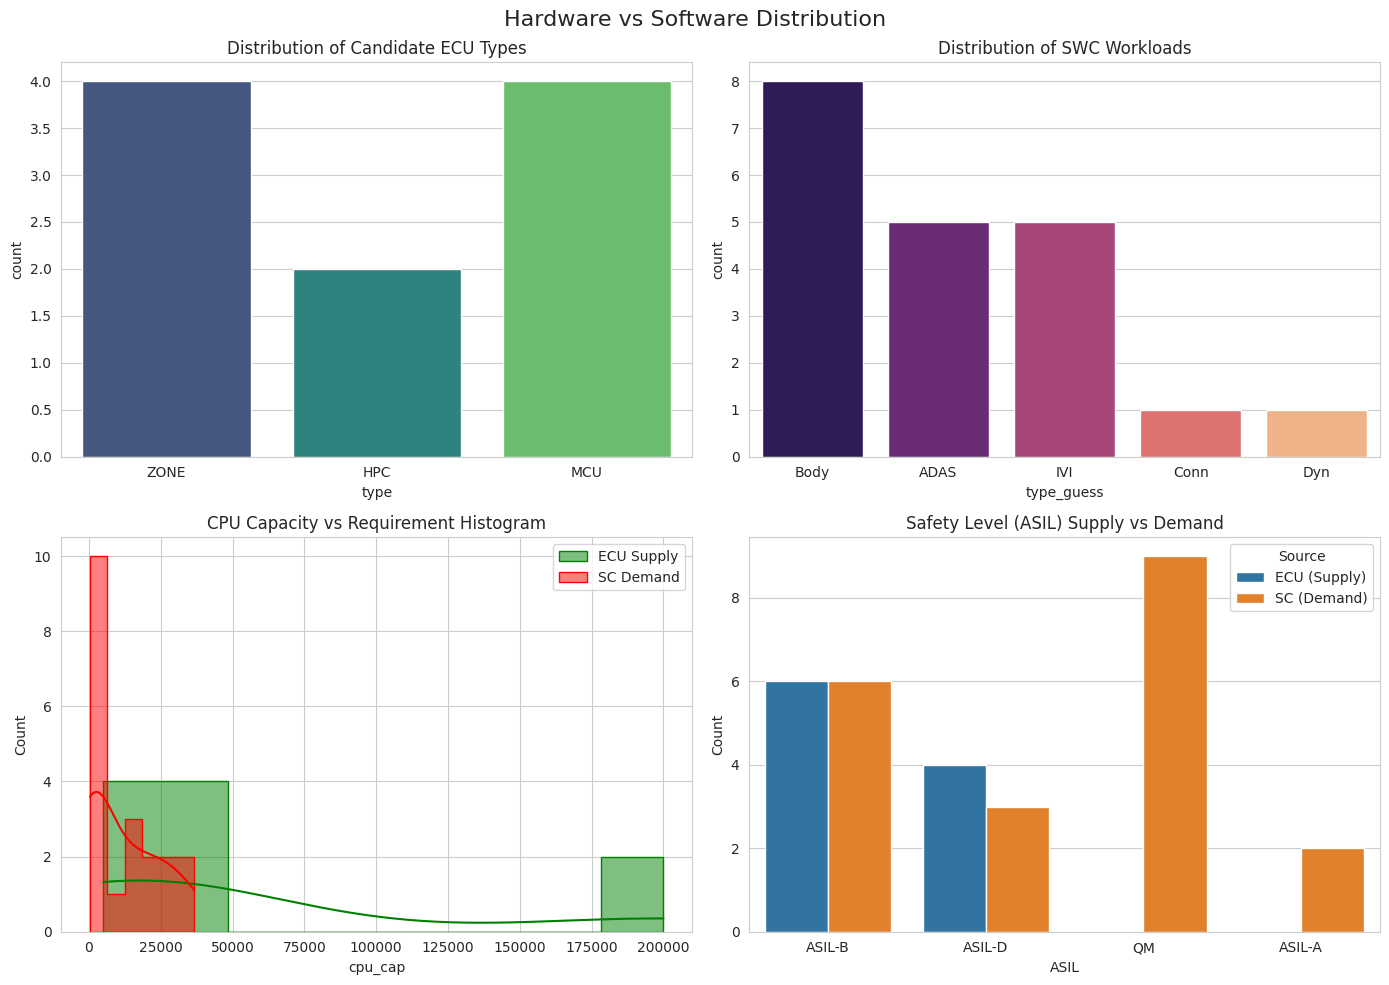

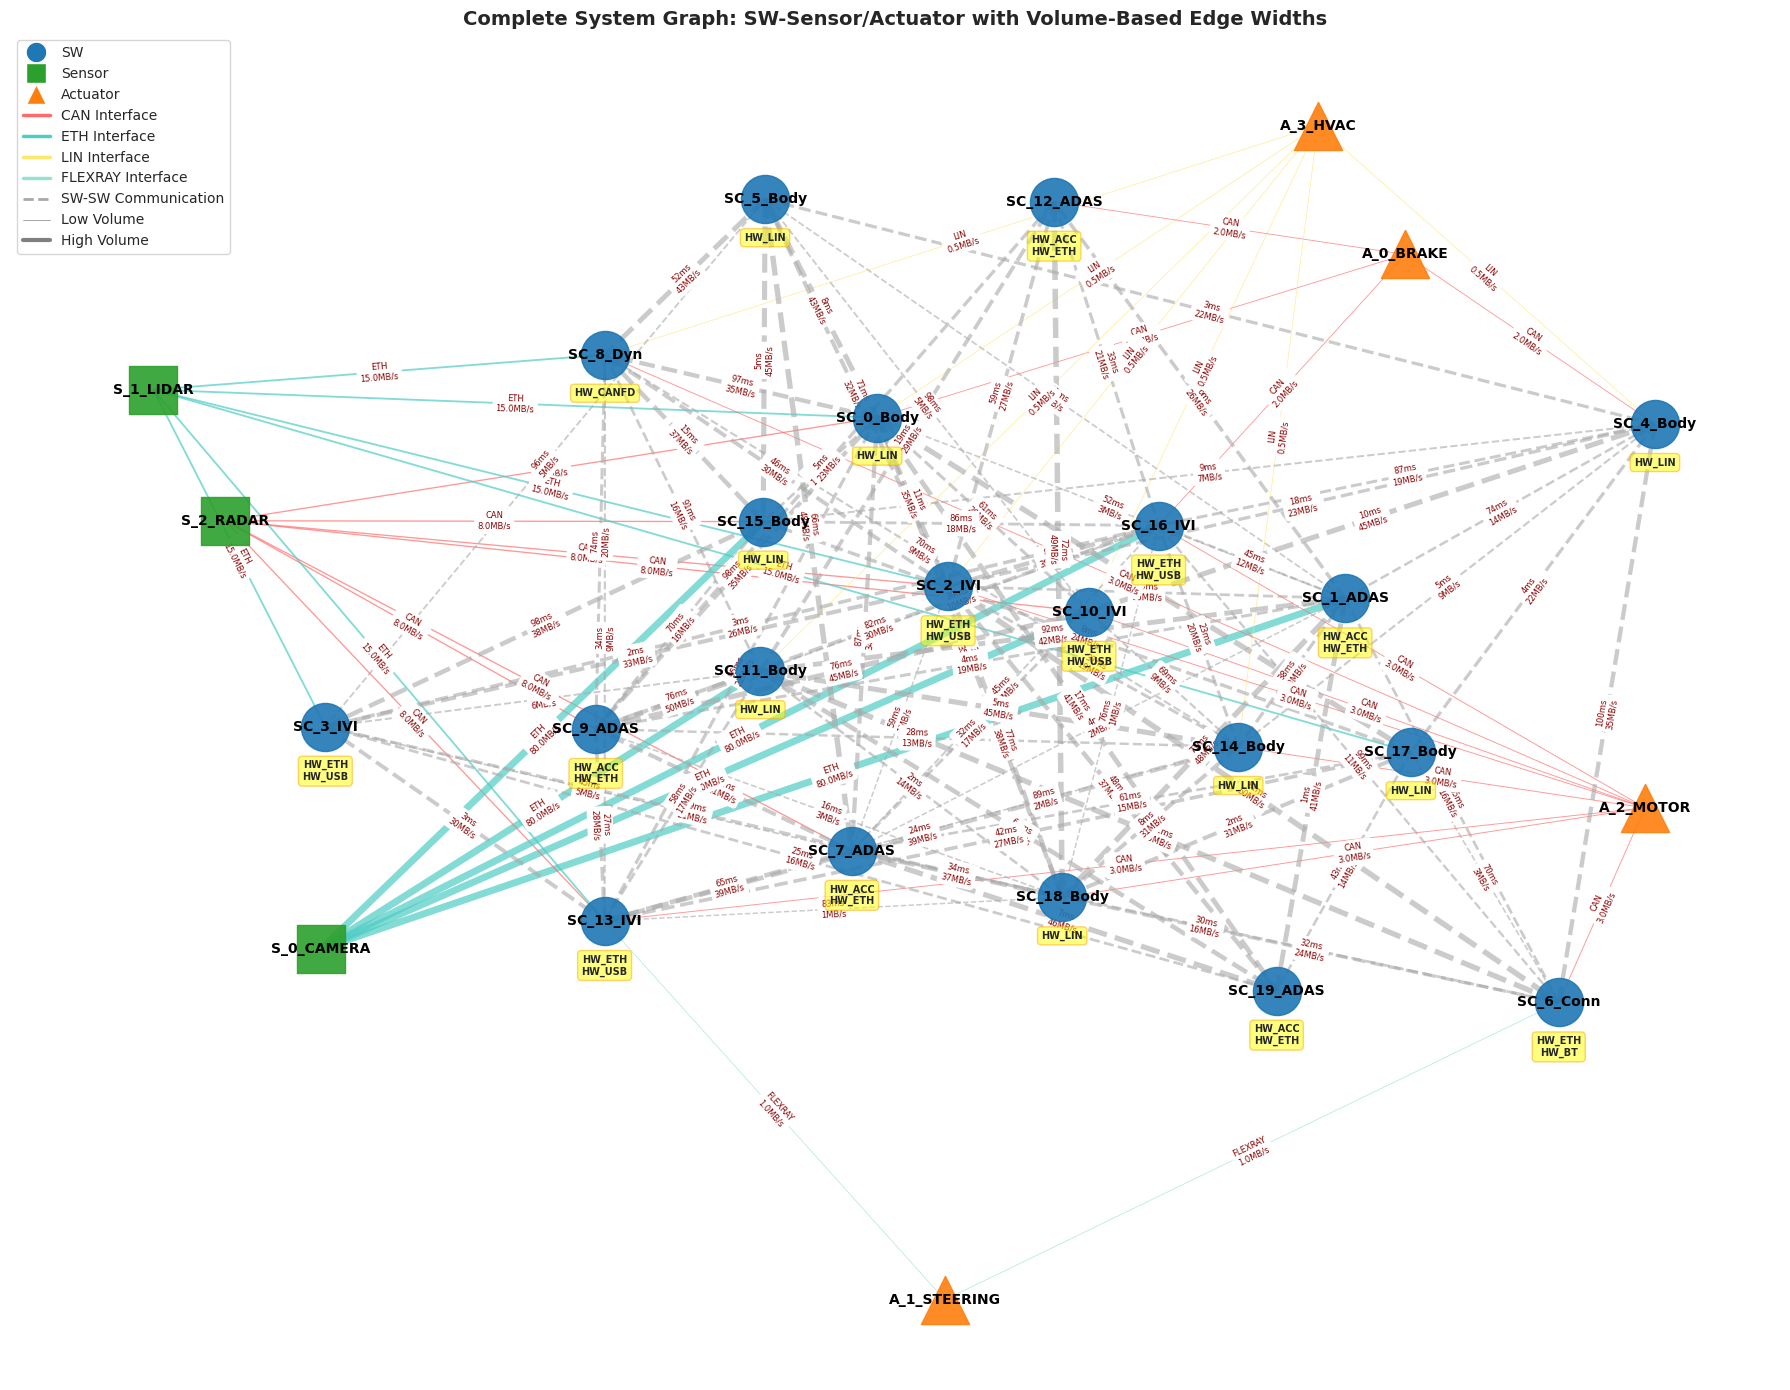

In [ ]:
class Visualization:
    def __init__(self):
        self.df_ecu = pd.DataFrame([vars(e) for e in ecus])
        self.df_sc = pd.DataFrame([vars(s) for s in scs])
        self.df_sensor = pd.DataFrame([vars(s) for s in sensors])
        self.df_actuator = pd.DataFrame([vars(a) for a in actuators])

    def display_sensors(self):
        print("Sensors:")
        display(self.df_sensor)

    def display_actuators(self):
        print("Actuators:")
        display(self.df_actuator) 

    def display_scs(self):
        print("Software Components:")
        display(self.df_sc)

    def display_ECUs(self):
        print("ECUs:")
        display(self.df_ecu)

    def display_data(self):
        # Display summary of generated ECUs
        self.display_ECUs()

        # Display summary of generated Software Components (SWs)
        self.display_scs()

        # Display summary of generated Sensors and Actuators
        self.display_sensors()
        self.display_actuators()

    def plot_charts(self):
        sns.set_style("whitegrid")
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('Hardware vs Software Distribution', fontsize=16)

        # ECU Distribution
        sns.countplot(x='type', data=self.df_ecu, ax=axes[0, 0], palette='viridis')
        axes[0, 0].set_title('Distribution of Candidate ECU Types')

        #  SWC Distribution in terms of Domain
        self.df_sc['type_guess'] = self.df_sc['id'].apply(lambda x: x.split('_')[-1])
        sns.countplot(x='type_guess', data=self.df_sc, ax=axes[0, 1], palette='magma')
        axes[0, 1].set_title('Distribution of SWC Workloads')

        # CPU Supply vs Demand
        sns.histplot(self.df_ecu['cpu_cap'], color='green', label='ECU Supply', ax=axes[1, 0], kde=True, element="step")
        sns.histplot(self.df_sc['cpu_req'], color='red', label='SC Demand', ax=axes[1, 0], kde=True, element="step")
        axes[1, 0].set_title('CPU Capacity vs Requirement Histogram')
        axes[1, 0].legend()

        # ASIL Supply vs Demand
        asil_map = {0: 'QM', 1: 'ASIL-A', 2: 'ASIL-B', 4: 'ASIL-D'}
        self.df_ecu['asil_str'] = self.df_ecu['asil_level'].map(asil_map)
        self.df_sc['asil_str'] = self.df_sc['asil_req'].map(asil_map)
        df_ecu_asil = self.df_ecu['asil_str'].value_counts().reset_index()
        df_ecu_asil.columns = ['ASIL', 'Count']
        df_ecu_asil['Source'] = 'ECU (Supply)'
        df_sc_asil = self.df_sc['asil_str'].value_counts().reset_index()
        df_sc_asil.columns = ['ASIL', 'Count']
        df_sc_asil['Source'] = 'SC (Demand)'
        df_combined = pd.concat([df_ecu_asil, df_sc_asil])
        sns.barplot(x='ASIL', y='Count', hue='Source', data=df_combined, ax=axes[1, 1])
        axes[1, 1].set_title('Safety Level (ASIL) Supply vs Demand')

        plt.tight_layout()
        plt.show()

    def plot_sw_sensor_actuator_graph_final(self,scs, sensors, actuators, comm_matrix):
        """
            SW-Sensor-Actuator connection graph visualization 
        """
        plt.figure(figsize=(18, 14)) 
        ax = plt.gca()
        G = nx.Graph()
        
        # Sensor and actuator lookup dictionaries
        sensor_dict = {s.id: s for s in sensors}
        actuator_dict = {a.id: a for a in actuators}
        
        # Add Nodes
        for sc in scs:
            G.add_node(sc.id, node_type='SW', domain=sc.domain, hw_required=sc.hw_required)
        for s in sensors:
            G.add_node(s.id, node_type='Sensor', sensor_type=s.type, interface=s.interface, volume=s.volume)
        for a in actuators:
            G.add_node(a.id, node_type='Actuator', actuator_type=a.type, interface=a.interface, volume=a.volume)
            
        # Add Edges: SW -> Sensor/Actuator (with volume information)
        for sc in scs:
            for sid in getattr(sc, 'sensors', []):
                sensor_obj = sensor_dict.get(sid)
                if sensor_obj:
                    G.add_edge(sc.id, sid, edge_type='sensor', interface=sensor_obj.interface, volume=sensor_obj.volume)
            for aid in getattr(sc, 'actuators', []):
                actuator_obj = actuator_dict.get(aid)
                if actuator_obj:
                    G.add_edge(sc.id, aid, edge_type='actuator', interface=actuator_obj.interface, volume=actuator_obj.volume)
        
        # Add Edges: SW -> SW (communication links)
        for comm in comm_matrix:
            G.add_edge(comm['src'], comm['dst'], edge_type='comm', 
                    volume=comm['volume'], latency=comm['max_latency'])

        node_type_map = {
            'SW': ('tab:blue', 'o'), 
            'Sensor': ('tab:green', 's'), 
            'Actuator': ('tab:orange', '^')
        }
        
        interface_colors = {
            'CAN': '#FF6B6B',      
            'ETH': '#4ECDC4',     
            'LIN': '#FFE66D',      
            'FLEXRAY': '#95E1D3',
        }
        
        node_labels = {n: n for n in G.nodes()}

        pos = nx.spring_layout(G, seed=42, k=1.5, iterations=50)

        # Draw nodes
        for ntype, (color, shape) in node_type_map.items():
            nodelist = [n for n, d in G.nodes(data=True) if d['node_type'] == ntype]
            nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_shape=shape,
                                node_color=color, label=ntype, alpha=0.9, node_size=1200)

        
        #Draw SW-Sensor ve SW-Actuator edges
        for u, v, d in G.edges(data=True):
            if d.get('edge_type') in ['sensor', 'actuator']:
                interface = d.get('interface', 'CAN')
                color = interface_colors.get(interface, 'gray')
                # Thicjkness based on volume
                volume = d.get('volume', 1.0)
                width = 0.5 + (volume / 80.0) * 4.5  # 80 max volume (CAMERA)
                nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=color, width=width, alpha=0.7)
        
        # SW-SW Communication edges
        for u, v, d in G.edges(data=True):
            if d.get('edge_type') == 'comm':
                volume = d.get('volume', 1)
                width = 1 + (volume / 50) * 3
                nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color='darkgray', 
                                    width=width, alpha=0.6, style='dashed')

        # Node labels
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_weight='bold')

        # postion labels: HW Required
        for sc in scs:
            if sc.id in pos:
                node_pos = pos[sc.id]
                hw_text = '\n'.join(sc.hw_required) if sc.hw_required else 'No HW'
                ax.text(node_pos[0], node_pos[1] - 0.05, hw_text, 
                    fontsize=7, ha='center', va='top',
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.5, edgecolor='orange', linewidth=1),
                    weight='bold')
        
        # Edge labels: Interface ve Volume information
        edge_labels = {}
        for u, v, d in G.edges(data=True):
            if d.get('edge_type') in ['sensor', 'actuator']:
                interface = d.get('interface', 'CAN')
                volume = d.get('volume', 0)
                edge_labels[(u, v)] = f"{interface}\n{volume}MB/s"
            elif d.get('edge_type') == 'comm':
                latency = d.get('latency', '')
                volume = d.get('volume', 0)
                edge_labels[(u, v)] = f"{latency}ms\n{volume}MB/s"
        
        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6, font_color='darkred')

        # Legend
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='SW', markerfacecolor='tab:blue', markersize=15),
            Line2D([0], [0], marker='s', color='w', label='Sensor', markerfacecolor='tab:green', markersize=15),
            Line2D([0], [0], marker='^', color='w', label='Actuator', markerfacecolor='tab:orange', markersize=15),
            Line2D([0], [0], color='#FF6B6B', lw=2.5, label='CAN Interface'),
            Line2D([0], [0], color='#4ECDC4', lw=2.5, label='ETH Interface'),
            Line2D([0], [0], color='#FFE66D', lw=2.5, label='LIN Interface'),
            Line2D([0], [0], color='#95E1D3', lw=2.5, label='FLEXRAY Interface'),
            Line2D([0], [0], color='darkgray', lw=2, linestyle='dashed', label='SW-SW Communication'),
            Line2D([0], [0], color='gray', lw=0.5, label='Low Volume'),
            Line2D([0], [0], color='gray', lw=3, label='High Volume'),
        ]
        
        plt.legend(handles=legend_elements, loc='upper left', fontsize=10)
        plt.title('Complete System Graph: SW-Sensor/Actuator with Volume-Based Edge Widths', fontsize=14, weight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()



visualizer = Visualization()
visualizer.display_data()
visualizer.plot_charts()
visualizer.plot_sw_sensor_actuator_graph_final(scs, sensors, actuators, comm_matrix)

In [146]:
# Gurobi ile SW-ECU Atama Optimizasyonu
# !pip install gurobipy
import gurobipy as gp
from gurobipy import GRB
import numpy as np

def optimize_sw_to_ecu_assignment(scs, ecus):
    """
    SW'leri ECU'lara ata (HW gereksinimleri dikkate alarak)
    Gurobi ile maliyeti minimize et
    """
    
    # Model oluştur
    model = gp.Model('SW_ECU_Assignment')
    
    n_sw = len(scs)
    n_ecu = len(ecus)
    
    print(f"Optimizasyon: {n_sw} SW -> {n_ecu} ECU")
    
    # Karar değişkenleri: x[i,j] = SW_i ECU_j'ye atanıyor mı?
    x = {}
    for i in range(n_sw):
        for j in range(n_ecu):
            # HW uygunluğu kontrol et
            sw_hw_req = set(scs[i].hw_required)
            ecu_hw_off = set(ecus[j].hw_offered)
            
            # Eğer ECU SW'nin gerektirdiği HW'yi sunmuyorsa, atamayı yasakla
            if sw_hw_req.issubset(ecu_hw_off):
                x[i, j] = model.addVar(vtype=GRB.BINARY, name=f'x_{i}_{j}')
            # else: atama yapılamaz, değişken oluşturma
    
    model.update()
    
    # Kısıtlar
    
    # 1. Her SW tam olarak 1 ECU'ya atanmalı
    for i in range(n_sw):
        possible_ecus = [j for j in range(n_ecu) if (i, j) in x]
        if len(possible_ecus) > 0:
            model.addConstr(gp.quicksum(x[i, j] for j in possible_ecus) == 1, 
                          name=f'assign_sw_{i}')
    
    # 2. ECU kapasiteleri aşılmamalı
    for j in range(n_ecu):
        # CPU kapasitesi
        cpu_constraint = gp.quicksum(scs[i].cpu_req * x[i, j] 
                                     for i in range(n_sw) if (i, j) in x)
        model.addConstr(cpu_constraint <= ecus[j].cpu_cap, 
                       name=f'cpu_cap_ecu_{j}')
        
        # RAM kapasitesi
        ram_constraint = gp.quicksum(scs[i].ram_req * x[i, j] 
                                     for i in range(n_sw) if (i, j) in x)
        model.addConstr(ram_constraint <= ecus[j].ram_cap, 
                       name=f'ram_cap_ecu_{j}')
        
        # ROM kapasitesi
        rom_constraint = gp.quicksum(scs[i].rom_req * x[i, j] 
                                     for i in range(n_sw) if (i, j) in x)
        model.addConstr(rom_constraint <= ecus[j].rom_cap, 
                       name=f'rom_cap_ecu_{j}')
    
    # Amaç: Toplam maliyeti minimize et
    # Atanan SW'lerin ECU maliyeti
    objective = gp.quicksum(ecus[j].cost * gp.quicksum(x[i, j] for i in range(n_sw) if (i, j) in x)
                           for j in range(n_ecu))
    model.setObjective(objective, GRB.MINIMIZE)
    
    # Optimizasyon
    model.optimize()
    
    # Sonuçlar
    print(f"\n=== Optimizasyon Sonuçları ===")
    print(f"Status: {model.status}")
    print(f"Optimal Maliyet: {model.objVal}")
    
    # Atamalar
    assignments = {}
    for i in range(n_sw):
        for j in range(n_ecu):
            if (i, j) in x and x[i, j].X > 0.5:
                assignments[scs[i].id] = ecus[j].id
                print(f"{scs[i].id} -> {ecus[j].id}")
    
    return model, x, assignments

# Çalıştır
print("Gurobi optimization başlatılıyor...")
model, x, assignments = optimize_sw_to_ecu_assignment(scs, ecus)

Gurobi optimization başlatılıyor...
Optimizasyon: 20 SW -> 10 ECU
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-13850HX, instruction set [SSE2|AVX|AVX2]
Thread count: 28 physical cores, 28 logical processors, using up to 28 threads

Optimize a model with 44 rows, 82 columns and 328 nonzeros (Min)
Model fingerprint: 0x25a8e4a9
Model has 82 linear objective coefficients
Variable types: 0 continuous, 82 integer (82 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [5e+01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]
Found heuristic solution: objective 6450.0000000
Presolve removed 31 rows and 46 columns
Presolve time: 0.00s
Presolved: 13 rows, 36 columns, 72 nonzeros
Variable types: 0 continuous, 36 integer (36 binary)
Found heuristic solution: objective 5450.0000000

Root relaxation: cutoff, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1

Optimization result visualization başlatılıyor...

📊 Görselleştirme: 14 atanan SW, 5 kullanılan ECU


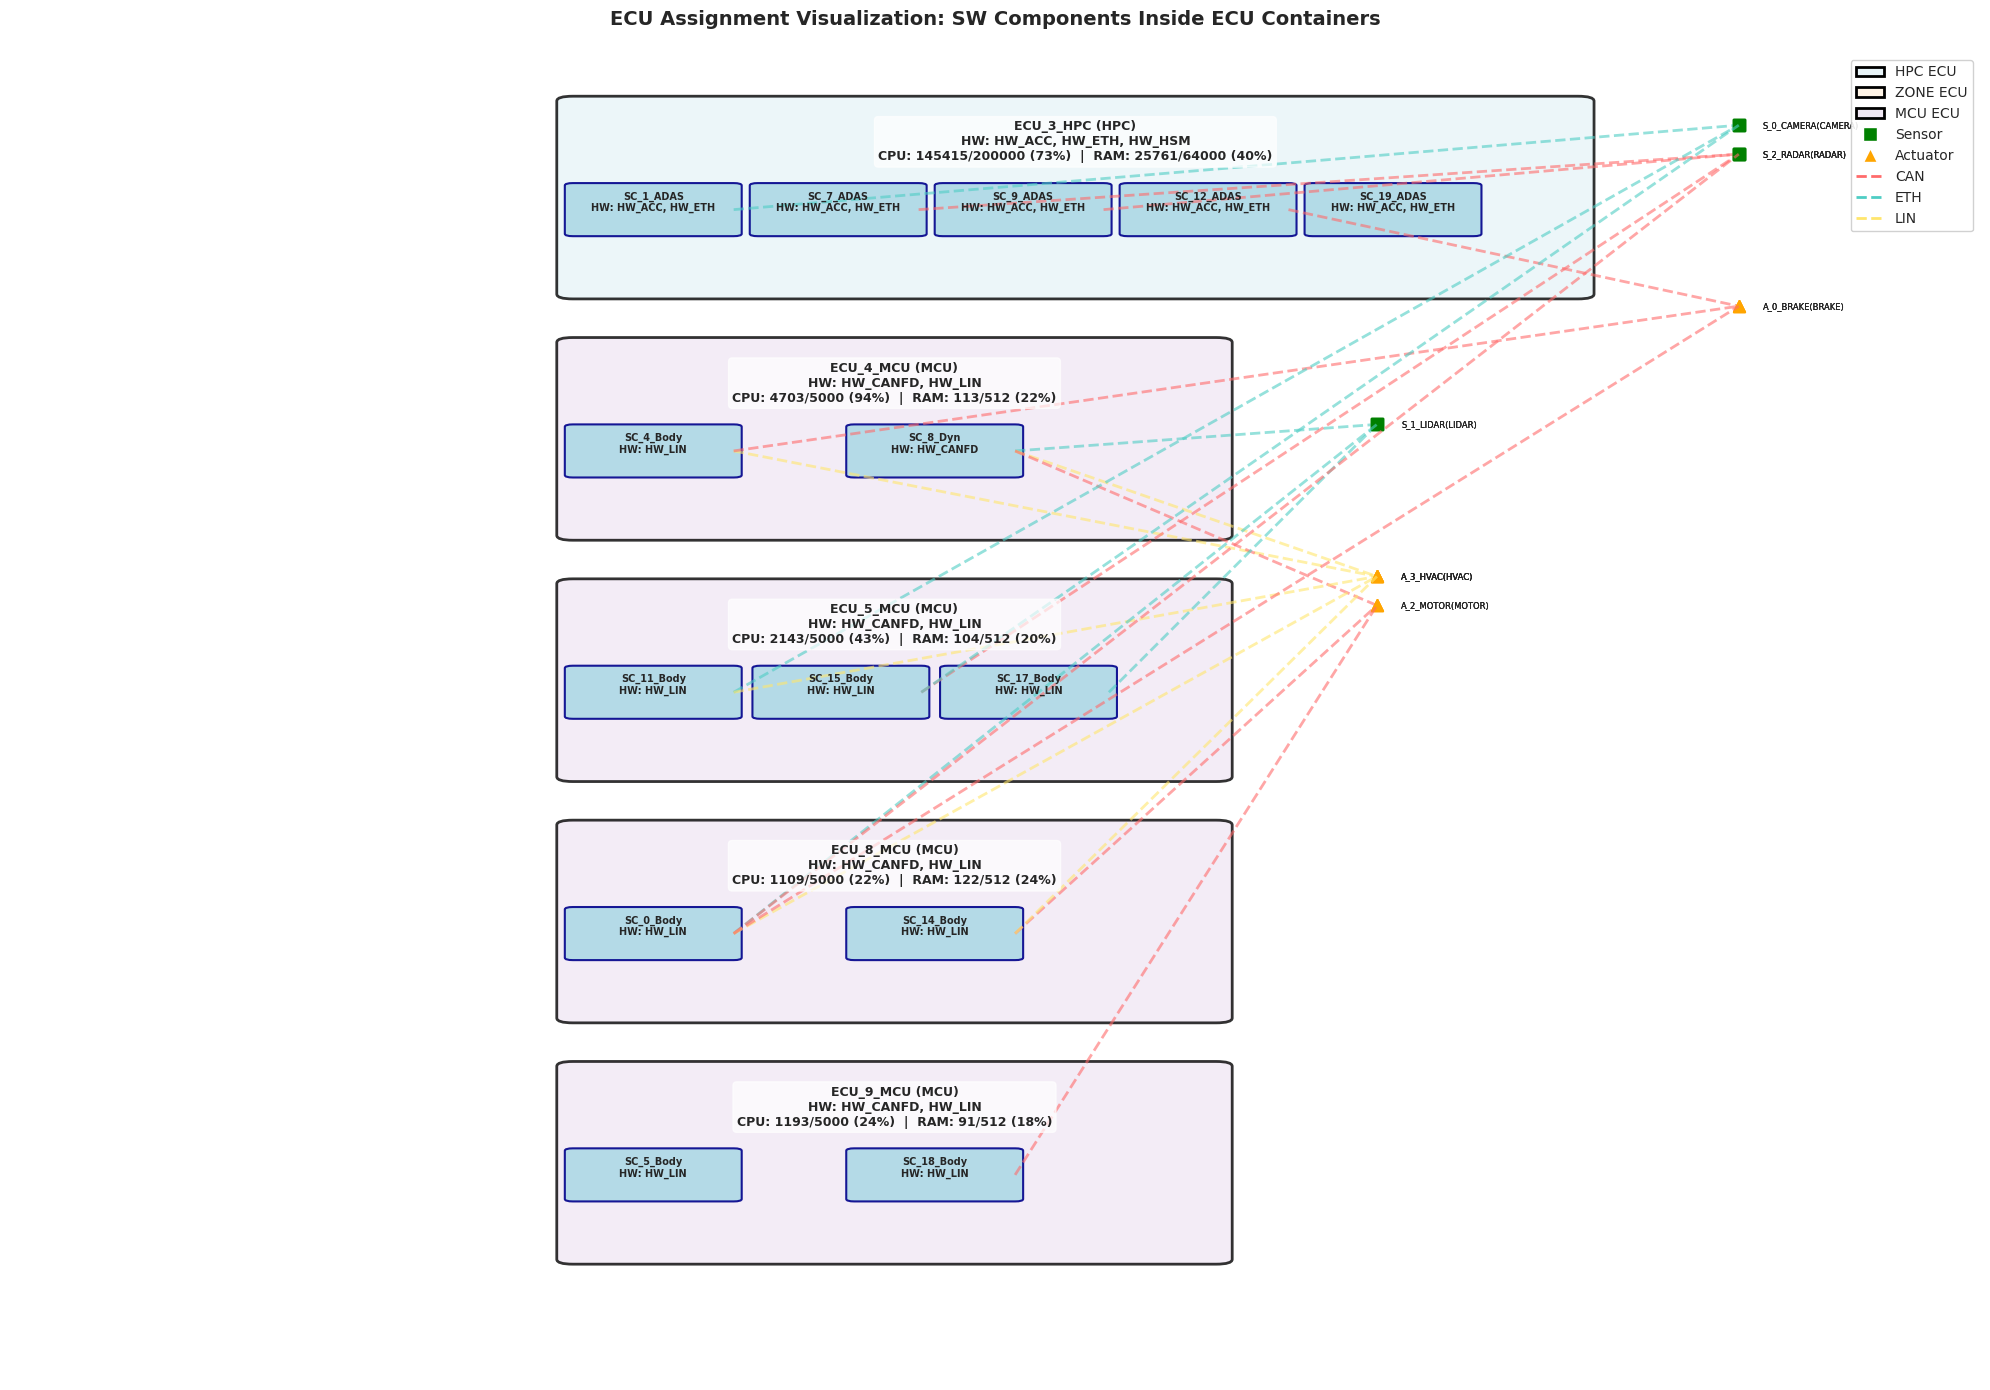


DETAILED ASSIGNMENT REPORT

ECU_3_HPC (HPC) - Cost: $1000
  Hardware Offered: HW_ACC, HW_ETH, HW_HSM
  Capacity: CPU=200000 DMIPS | RAM=64000MB | ROM=256000MB
  Utilization:
    CPU: 145415/200000 (72.7%)
    RAM: 25761/64000 (40.3%)
    ROM: 604/256000 (0.2%)
  Assigned SWs: 5

    └─ SC_12_ADAS (ADAS)
       Requirements: CPU=27130 | RAM=4910MB | ROM=103MB
       Hardware Required: HW_ACC, HW_ETH
       Actuators: A_0_BRAKE(BRAKE, CAN)

    └─ SC_19_ADAS (ADAS)
       Requirements: CPU=21913 | RAM=6646MB | ROM=130MB
       Hardware Required: HW_ACC, HW_ETH

    └─ SC_1_ADAS (ADAS)
       Requirements: CPU=24105 | RAM=3273MB | ROM=105MB
       Hardware Required: HW_ACC, HW_ETH
       Sensors: S_0_CAMERA(CAMERA, ETH, 80.0MB/s)

    └─ SC_7_ADAS (ADAS)
       Requirements: CPU=35599 | RAM=7066MB | ROM=142MB
       Hardware Required: HW_ACC, HW_ETH
       Sensors: S_2_RADAR(RADAR, CAN, 8.0MB/s)

    └─ SC_9_ADAS (ADAS)
       Requirements: CPU=36668 | RAM=3866MB | ROM=124MB
       Hardw

In [147]:
def visualize_optimization_result(scs, ecus, sensors, actuators, assignments):
    """
    ECU'ları kutular olarak görselleştir, SW'leri içinde göster
    """
    from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
    from matplotlib.patches import ConnectionPatch
    
    # Lookup dictionaries
    sc_dict = {s.id: s for s in scs}
    ecu_dict = {e.id: e for e in ecus}
    sensor_dict = {s.id: s for s in sensors}
    actuator_dict = {a.id: a for a in actuators}
    
    if not assignments:
        print("❌ Hiçbir atama yapılmadı. Lütfen optimize fonksiyonunu çalıştırın.")
        return
    
    # Create reverse mapping: ECU -> list of SWs
    ecu_to_sws = {}
    for sw_id, ecu_id in assignments.items():
        if ecu_id not in ecu_to_sws:
            ecu_to_sws[ecu_id] = []
        ecu_to_sws[ecu_id].append(sw_id)
    
    print(f"📊 Görselleştirme: {len(assignments)} atanan SW, {len(ecu_to_sws)} kullanılan ECU")
    
    # ECU'ları filtreле (sadece atanan)
    assigned_ecus = [e for e in ecus if e.id in ecu_to_sws]
    
    fig, ax = plt.subplots(figsize=(20, 14))
    
    # ECU rengini tip'e göre belirle
    ecu_colors = {
        'HPC': '#E8F4F8',
        'ZONE': '#FFF4E6',
        'MCU': '#F0E8F4'
    }
    
    # Interface renkleri
    interface_colors = {
        'CAN': '#FF6B6B',
        'ETH': '#4ECDC4',
        'LIN': '#FFE66D',
        'FLEXRAY': '#95E1D3',
    }
    
    # Sensor/actuator dışarıda node'lar
    sensor_positions = {}
    actuator_positions = {}
    
    # Toplam SW'lerin sensor/actuatorlarını topla
    all_sw_sensors = {}
    all_sw_actuators = {}
    for ecu_id, sw_ids in ecu_to_sws.items():
        for sw_id in sw_ids:
            sc = sc_dict[sw_id]
            if hasattr(sc, 'sensors'):
                for sid in sc.sensors:
                    if sid not in all_sw_sensors:
                        all_sw_sensors[sid] = []
                    all_sw_sensors[sid].append(sw_id)
            if hasattr(sc, 'actuators'):
                for aid in sc.actuators:
                    if aid not in all_sw_actuators:
                        all_sw_actuators[aid] = []
                    all_sw_actuators[aid].append(sw_id)
    
    # ECU kutularını ve SW'leri çiz
    ecu_box_height = 8
    ecu_y_spacing = 10  # ECU'lar arasındaki dikey mesafe
    ecu_positions = {}
    
    for idx, ecu in enumerate(assigned_ecus):
        y_pos = (len(assigned_ecus) - 1) * ecu_y_spacing - idx * ecu_y_spacing
        x_pos = 5
        
        sw_ids = ecu_to_sws[ecu.id]
        
        # CPU/RAM kullanımını hesapla
        total_cpu = sum(sc_dict[sw_id].cpu_req for sw_id in sw_ids)
        total_ram = sum(sc_dict[sw_id].ram_req for sw_id in sw_ids)
        
        cpu_util = 100 * total_cpu / ecu.cpu_cap if ecu.cpu_cap > 0 else 0
        ram_util = 100 * total_ram / ecu.ram_cap if ecu.ram_cap > 0 else 0
        
        # ECU kutusunun genişliği SW sayısına göre
        box_width = max(8, len(sw_ids) * 2.5)
        
        # ECU kutusu çiz
        color = ecu_colors.get(ecu.type, '#EEEEEE')
        fancy_box = FancyBboxPatch((x_pos, y_pos), box_width, ecu_box_height,
                                   boxstyle="round,pad=0.2", 
                                   edgecolor='black', facecolor=color,
                                   linewidth=2, alpha=0.8)
        ax.add_patch(fancy_box)
        
        # ECU başlığı
        header_text = f"{ecu.id} ({ecu.type})\n"
        header_text += f"HW: {', '.join(ecu.hw_offered)}\n"
        header_text += f"CPU: {total_cpu}/{ecu.cpu_cap} ({cpu_util:.0f}%)  |  RAM: {total_ram}/{ecu.ram_cap} ({ram_util:.0f}%)"
        
        ax.text(x_pos + box_width/2, y_pos + ecu_box_height - 0.8, header_text,
               fontsize=9, ha='center', va='top', weight='bold',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        # SW'leri kutu içine çiz
        sw_x_start = x_pos + 0.5
        sw_spacing = (box_width - 1) / max(len(sw_ids), 1)
        
        for sw_idx, sw_id in enumerate(sw_ids):
            sc = sc_dict[sw_id]
            sw_x = sw_x_start + sw_idx * sw_spacing + 0.5
            sw_y = y_pos + 3.5
            
            # SW kutusu
            sw_box = FancyBboxPatch((sw_x - 1, sw_y - 1), 2, 2,
                                    boxstyle="round,pad=0.1",
                                    edgecolor='darkblue', facecolor='lightblue',
                                    linewidth=1.5, alpha=0.9)
            ax.add_patch(sw_box)
            
            # SW adı ve HW gereksinimi
            sw_text = f"{sw_id}\nHW: {', '.join(sc.hw_required)}"
            ax.text(sw_x, sw_y + 0.3, sw_text,
                   fontsize=7, ha='center', va='center', weight='bold')
            
            # Sensor/actuator bağlantılarını çiz
            if hasattr(sc, 'sensors'):
                for s_idx, sensor_id in enumerate(sc.sensors):
                    if sensor_id not in sensor_positions:
                        # Sensor'ü kutu dışında konumlandır
                        sensor_idx = len(sensor_positions)
                        sensor_positions[sensor_id] = (x_pos + box_width + 2, y_pos + ecu_box_height - 1 - sensor_idx * 1.2)
                    
                    sensor_x, sensor_y = sensor_positions[sensor_id]
                    
                    # Sensor noktası
                    sensor_obj = sensor_dict[sensor_id]
                    ax.plot(sensor_x, sensor_y, 'gs', markersize=8)
                    ax.text(sensor_x + 0.3, sensor_y, f"{sensor_id}({sensor_obj.type})",
                           fontsize=6, va='center')
                    
                    # Bağlantı çizgisi (interface renginde)
                    interface = sensor_obj.interface
                    color = interface_colors.get(interface, 'gray')
                    ax.plot([sw_x + 1, sensor_x], [sw_y, sensor_y],
                           color=color, linewidth=2, alpha=0.6, linestyle='--')
            
            if hasattr(sc, 'actuators'):
                for a_idx, actuator_id in enumerate(sc.actuators):
                    if actuator_id not in actuator_positions:
                        # Actuator'ü kutu dışında konumlandır
                        actuator_idx = len(actuator_positions)
                        actuator_positions[actuator_id] = (x_pos + box_width + 2, y_pos - 0.5 - actuator_idx * 1.2)
                    
                    actuator_x, actuator_y = actuator_positions[actuator_id]
                    
                    # Actuator noktası
                    actuator_obj = actuator_dict[actuator_id]
                    ax.plot(actuator_x, actuator_y, '^', color='orange', markersize=8)
                    ax.text(actuator_x + 0.3, actuator_y, f"{actuator_id}({actuator_obj.type})",
                           fontsize=6, va='center')
                    
                    # Bağlantı çizgisi (interface renginde)
                    interface = actuator_obj.interface
                    color = interface_colors.get(interface, 'gray')
                    ax.plot([sw_x + 1, actuator_x], [sw_y, actuator_y],
                           color=color, linewidth=2, alpha=0.6, linestyle='--')
        
        ecu_positions[ecu.id] = (x_pos, y_pos, box_width, ecu_box_height)
    
    # Legend
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, fc=ecu_colors['HPC'], ec='black', linewidth=2, label='HPC ECU'),
        plt.Rectangle((0, 0), 1, 1, fc=ecu_colors['ZONE'], ec='black', linewidth=2, label='ZONE ECU'),
        plt.Rectangle((0, 0), 1, 1, fc=ecu_colors['MCU'], ec='black', linewidth=2, label='MCU ECU'),
        Line2D([0], [0], marker='s', color='w', label='Sensor', 
              markerfacecolor='green', markersize=10),
        Line2D([0], [0], marker='^', color='w', label='Actuator', 
              markerfacecolor='orange', markersize=10),
        Line2D([0], [0], color='#FF6B6B', lw=2, linestyle='--', label='CAN'),
        Line2D([0], [0], color='#4ECDC4', lw=2, linestyle='--', label='ETH'),
        Line2D([0], [0], color='#FFE66D', lw=2, linestyle='--', label='LIN'),
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)
    
    ax.set_xlim(-2, max(ecu_positions[e.id][0] + ecu_positions[e.id][2] for e in assigned_ecus) + 5)
    ax.set_ylim(-5, len(assigned_ecus) * 10)
    ax.axis('off')
    
    plt.title('ECU Assignment Visualization: SW Components Inside ECU Containers', 
             fontsize=14, weight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Detailed report
    print("\n" + "="*80)
    print("DETAILED ASSIGNMENT REPORT")
    print("="*80)
    
    for ecu in assigned_ecus:
        ecu_id = ecu.id
        sw_ids = ecu_to_sws[ecu_id]
        
        total_cpu = sum(sc_dict[sw_id].cpu_req for sw_id in sw_ids)
        total_ram = sum(sc_dict[sw_id].ram_req for sw_id in sw_ids)
        total_rom = sum(sc_dict[sw_id].rom_req for sw_id in sw_ids)
        
        print(f"\n{ecu_id} ({ecu.type}) - Cost: ${ecu.cost}")
        print(f"  Hardware Offered: {', '.join(ecu.hw_offered)}")
        print(f"  Capacity: CPU={ecu.cpu_cap} DMIPS | RAM={ecu.ram_cap}MB | ROM={ecu.rom_cap}MB")
        print(f"  Utilization:")
        print(f"    CPU: {total_cpu}/{ecu.cpu_cap} ({100*total_cpu/ecu.cpu_cap:.1f}%)")
        print(f"    RAM: {total_ram}/{ecu.ram_cap} ({100*total_ram/ecu.ram_cap:.1f}%)")
        print(f"    ROM: {total_rom}/{ecu.rom_cap} ({100*total_rom/ecu.rom_cap:.1f}%)")
        print(f"  Assigned SWs: {len(sw_ids)}")
        
        for sw_id in sorted(sw_ids):
            sc = sc_dict[sw_id]
            print(f"\n    └─ {sw_id} ({sc.domain})")
            print(f"       Requirements: CPU={sc.cpu_req} | RAM={sc.ram_req}MB | ROM={sc.rom_req}MB")
            print(f"       Hardware Required: {', '.join(sc.hw_required)}")
            
            sensors = getattr(sc, 'sensors', [])
            actuators = getattr(sc, 'actuators', [])
            
            if sensors:
                sensor_info = []
                for sid in sensors:
                    if sid in sensor_dict:
                        s_obj = sensor_dict[sid]
                        sensor_info.append(f"{sid}({s_obj.type}, {s_obj.interface}, {s_obj.volume}MB/s)")
                if sensor_info:
                    print(f"       Sensors: {', '.join(sensor_info)}")
            
            if actuators:
                actuator_info = []
                for aid in actuators:
                    if aid in actuator_dict:
                        a_obj = actuator_dict[aid]
                        actuator_info.append(f"{aid}({a_obj.type}, {a_obj.interface})")
                if actuator_info:
                    print(f"       Actuators: {', '.join(actuator_info)}")

# Sonuçları görselleştir
print("Optimization result visualization başlatılıyor...\n")
visualize_optimization_result(scs, ecus, sensors, actuators, assignments)

In [ ]:
  def optimize_pareto_front(self, scs, ecus, num_solutions=5):
        """
        Generate Pareto front solutions with multiple objectives.
        
        Objectives:
        1. Minimize total cost
        2. Minimize number of ECUs used
        3. Minimize peak ECU utilization (load balancing)
        
        Args:
            scs: List of SoftwareComponent objects
            ecus: List of CandidateECU objects
            num_solutions: Number of Pareto-optimal solutions to find
            
        Returns:
            List of dictionaries, each containing {sc_id: ecu_id} assignment
            plus metadata about cost, num_ecus_used, and max_utilization
        """
        
        print("\n=== Pareto Front Optimization ===")
        self.pre_optimization_analysis(scs, ecus)
        
        pareto_solutions = []
        
        # Strategy: Weighted sum approach - vary weights between objectives
        # Weight 1: Cost minimization (w1)
        # Weight 2: Number of ECUs minimization (w2)
        # Weight 3: Load balancing (w3)
        
        for solution_idx in range(num_solutions):
            # Vary weights to explore different trade-offs
            # Linear progression from cost-focused to ECU-count-focused
            alpha = solution_idx / max(1, num_solutions - 1)
            w_cost = 1.0 - alpha * 0.5  # 1.0 to 0.5
            w_ecus = alpha * 0.5         # 0.0 to 0.5
            
            model = gp.Model(f"SW_ECU_Assignment_Pareto_{solution_idx}")
            model.setParam('OutputFlag', 0)
            
            # Binary assignment variables
            x = {}
            for i, sc in enumerate(scs):
                for j, ecu in enumerate(ecus):
                    if set(sc.hw_required).issubset(set(ecu.hw_offered)):
                        x[i, j] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")
            
            # Auxiliary variable: Whether ECU j is used
            y = {}
            for j in range(len(ecus)):
                y[j] = model.addVar(vtype=GRB.BINARY, name=f"y_{j}")
            
            # Constraint: Each SC assigned to exactly 1 ECU
            for i, sc in enumerate(scs):
                feasible_ecus = [j for j in range(len(ecus)) if (i, j) in x]
                if feasible_ecus:
                    model.addConstr(gp.quicksum(x[i, j] for j in feasible_ecus) == 1, 
                                  name=f"assign_{i}")
            
            # Constraint: ECU usage tracking
            for j in range(len(ecus)):
                for i, sc in enumerate(scs):
                    if (i, j) in x:
                        model.addConstr(x[i, j] <= y[j], name=f"usage_{i}_{j}")
            
            # Capacity constraints
            for j, ecu in enumerate(ecus):
                cpu_constraint = gp.quicksum(x[i, j] * scs[i].cpu_req 
                                            for i in range(len(scs)) if (i, j) in x) <= ecu.cpu_cap
                model.addConstr(cpu_constraint, name=f"cpu_{j}")
                
                ram_constraint = gp.quicksum(x[i, j] * scs[i].ram_req 
                                            for i in range(len(scs)) if (i, j) in x) <= ecu.ram_cap
                model.addConstr(ram_constraint, name=f"ram_{j}")
                
                rom_constraint = gp.quicksum(x[i, j] * scs[i].rom_req 
                                            for i in range(len(scs)) if (i, j) in x) <= ecu.rom_cap
                model.addConstr(rom_constraint, name=f"rom_{j}")
            
            # Multi-objective function (weighted sum)
            cost_expr = gp.quicksum(x[i, j] * ecus[j].cost for i, j in x)
            ecus_used_expr = gp.quicksum(y[j] for j in range(len(ecus)))
            
            # Combine objectives with weights
            objective = (w_cost * cost_expr / 1000.0 +  # Normalize cost
                        w_ecus * ecus_used_expr)
            model.setObjective(objective, GRB.MINIMIZE)
            
            model.optimize()
            
            if model.status == GRB.OPTIMAL:
                # Extract solution
                assignments = {}
                ecus_used = set()
                total_cost = 0
                
                for i, j in x:
                    if x[i, j].X > 0.5:
                        assignments[scs[i].id] = ecus[j].id
                        ecus_used.add(j)
                        total_cost += ecus[j].cost
                
                # Calculate max utilization
                max_util = 0
                for j in ecus_used:
                    cpu_used = sum(scs[i].cpu_req for i in range(len(scs)) 
                                  if (i, j) in x and x[i, j].X > 0.5)
                    cpu_util = cpu_used / ecus[j].cpu_cap
                    max_util = max(max_util, cpu_util)
                
                solution_data = {
                    'assignment': assignments,
                    'total_cost': total_cost,
                    'num_ecus_used': len(ecus_used),
                    'max_utilization': max_util,
                    'weights': {'cost': w_cost, 'ecus': w_ecus}
                }
                
                pareto_solutions.append(solution_data)
                print(f"\nSolution {solution_idx + 1}:")
                print(f"  Cost: ${total_cost:.2f}, ECUs Used: {len(ecus_used)}, Max Utilization: {max_util:.2%}")
            else:
                print(f"Solution {solution_idx + 1}: Infeasible (status {model.status})")
        
        return pareto_solutions

    def filter_pareto_optimal(self, solutions):
        """
        Filter solutions to keep only Pareto-optimal ones.
        A solution is Pareto-optimal if no other solution is better in all objectives.
        
        Args:
            solutions: List of solution dictionaries from optimize_pareto_front()
            
        Returns:
            List of Pareto-optimal solutions
        """
        if not solutions:
            return []
        
        pareto_optimal = []
        
        for candidate in solutions:
            is_dominated = False
            
            for other in solutions:
                if candidate is other:
                    continue
                
                # Check if 'other' dominates 'candidate'
                # (better or equal in all objectives)
                cost_better = other['total_cost'] <= candidate['total_cost']
                ecus_better = other['num_ecus_used'] <= candidate['num_ecus_used']
                util_better = other['max_utilization'] <= candidate['max_utilization']
                
                # If other is better in all three objectives and strictly better in at least one
                if (cost_better and ecus_better and util_better and
                    (other['total_cost'] < candidate['total_cost'] or
                     other['num_ecus_used'] < candidate['num_ecus_used'] or
                     other['max_utilization'] < candidate['max_utilization'])):
                    is_dominated = True
                    break
            
            if not is_dominated:
                pareto_optimal.append(candidate)
        
        return pareto_optimal

    def print_pareto_summary(self, pareto_solutions):
        """Print a formatted summary of Pareto-optimal solutions."""
        print("\n=== Pareto Front Summary ===")
        print(f"Total Pareto-optimal solutions: {len(pareto_solutions)}\n")
        print(f"{'#':<4} {'Cost':<12} {'ECUs':<8} {'Max Util':<12} {'Trade-off':<30}")
        print("-" * 66)
        
        for idx, sol in enumerate(pareto_solutions, 1):
            cost = sol['total_cost']
            ecus = sol['num_ecus_used']
            util = sol['max_utilization']
            
            # Determine trade-off description
            if cost < 5000:  # Arbitrary threshold
                tradeoff = "Cost-optimized"
            elif ecus < 3:
                tradeoff = "ECU-count optimized"
            else:
                tradeoff = "Balanced"
            
            print(f"{idx:<4} ${cost:<11.2f} {ecus:<8} {util:<11.1%} {tradeoff:<30}")



    def optimize_pareto_multi_objective(self, scs, ecus):
        """
        Generate Pareto front using Gurobi's native multi-objective optimization.
        
        Gurobi 9.0+ supports native multi-objective optimization where it automatically
        explores the Pareto front. This is the most modern approach.
        
        Args:
            scs: List of SoftwareComponent objects
            ecus: List of CandidateECU objects
            
        Returns:
            List of Pareto-optimal solutions at different priority levels
        """
        print("\n=== Pareto Front via Gurobi Multi-Objective ===")
        self.pre_optimization_analysis(scs, ecus)
        
        model = gp.Model("SW_ECU_Assignment_MultiObj")
        model.setParam('OutputFlag', 0)
        
        # Decision variables
        x = {}
        for i, sc in enumerate(scs):
            for j, ecu in enumerate(ecus):
                if set(sc.hw_required).issubset(set(ecu.hw_offered)):
                    x[i, j] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")
        
        y = {}
        for j in range(len(ecus)):
            y[j] = model.addVar(vtype=GRB.BINARY, name=f"y_{j}")
        
        # Constraints
        for i in range(len(scs)):
            feasible = [j for j in range(len(ecus)) if (i, j) in x]
            if feasible:
                model.addConstr(gp.quicksum(x[i, j] for j in feasible) == 1)
        
        for j in range(len(ecus)):
            for i in range(len(scs)):
                if (i, j) in x:
                    model.addConstr(x[i, j] <= y[j])
            
            cpu = gp.quicksum(x[i, j] * scs[i].cpu_req 
                             for i in range(len(scs)) if (i, j) in x) <= ecus[j].cpu_cap
            ram = gp.quicksum(x[i, j] * scs[i].ram_req 
                             for i in range(len(scs)) if (i, j) in x) <= ecus[j].ram_cap
            rom = gp.quicksum(x[i, j] * scs[i].rom_req 
                             for i in range(len(scs)) if (i, j) in x) <= ecus[j].rom_cap
            model.addConstr(cpu)
            model.addConstr(ram)
            model.addConstr(rom)
        
        # Define multiple objectives
        cost_expr = gp.quicksum(x[i, j] * ecus[j].cost for i, j in x)
        ecu_count_expr = gp.quicksum(y[j] for j in range(len(ecus)))
        
        # Model update required before setting ObjN
        model.update()
        
        # Set Gurobi multi-objective with priorities
        # Note: Gurobi 11.0+ uses this approach
        try:
            model.setAttr('ObjN', 0, cost_expr)
            model.setAttr('ObjNPriority', 0, 10)
            model.setAttr('ObjNRelTol', 0, 0.1)
            
            model.setAttr('ObjN', 1, ecu_count_expr)
            model.setAttr('ObjNPriority', 1, 5)
            model.setAttr('ObjNRelTol', 1, 0.05)
        except:
            # Fallback: If multi-objective not supported, just use weighted sum
            print("\nMulti-objective not supported in this Gurobi version.")
            print("Falling back to weighted sum approach...")
            objective = 10 * cost_expr + 5 * ecu_count_expr
            model.setObjective(objective, GRB.MINIMIZE)
        
        # Optimize with multi-objective
        model.optimize()
        
        pareto_solutions = []
        
        if model.status == GRB.OPTIMAL:
            # Get number of solutions in Pareto front
            num_solutions = model.SolCount
            print(f"\nGurobi found {num_solutions} Pareto-optimal solution(s)")
            
            for sol_idx in range(num_solutions):
                # Load solution
                model.params.SolutionNumber = sol_idx
                
                assignments = {}
                ecus_used = set()
                total_cost = 0
                
                for i, j in x:
                    if x[i, j].Xn > 0.5:
                        assignments[scs[i].id] = ecus[j].id
                        ecus_used.add(j)
                        total_cost += ecus[j].cost
                
                # Get objective values for this solution
                obj_cost = model.ObjNVal[0] if hasattr(model, 'ObjNVal') else total_cost
                
                solution_data = {
                    'assignment': assignments,
                    'total_cost': total_cost,
                    'num_ecus_used': len(ecus_used),
                    'solution_number': sol_idx,
                    'method': 'multi_objective'
                }
                pareto_solutions.append(solution_data)
                
                print(f"  Solution {sol_idx + 1}: Cost=${total_cost:.2f}, ECUs={len(ecus_used)}")
        else:
            print(f"Optimization failed with status {model.status}")
        
        return pareto_solutions